# coPTR comparison
> From read generation to correlation

In [9]:
%load_ext autoreload
%autoreload 2

import aptr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
MAX_MULT = 1
MIN_MULT = -2

# Synthetic data generation
Currently using multipliers from 1E-1 to 1E-4. The 1E-1 files are 5Gb each,
which approaches the limit of what I can shuffle in memory.

This should be run with the `aPTR` conda environment

In [11]:
# %%prun 
# Generate synthetic data
# dd = "../../experiments/synthetic/february2023"
dd = "../../experiments/simulated/october2023"
db = aptr.RnaDB()

! mkdir -p {dd}

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    print(f"Generating fastq_1E{multiplier}")

    # Catch crashes earlier if you iterate down
    try:
        os.mkdir(f"{dd}/fastq_1E{multiplier}")
    except FileExistsError:
        pass

    # Generate data
    abundances, log2_ptrs, otus = aptr.simulation_new.make_tables(
        n_genomes=20,
        n_samples=10,
        db=db,
        sparsity=0.5,
        multiplier=10**multiplier,
        fasta_dir="../../data/seqs",
        fasta_ext=".fna",
        fastq_out_path=f"{dd}/fastq_1E{multiplier}",
        downsample=.01,
        shuffle=False
    )

    # Save abundances, ptrs, otus
    abundances.to_csv(f"{dd}/abundances_1E{multiplier}.tsv", sep="\t")
    log2_ptrs.to_csv(f"{dd}/log2_ptrs_1E{multiplier}.tsv", sep="\t")
    otus.to_csv(f"{dd}/otus_1E{multiplier}.tsv", sep="\t")


0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering
Generating fastq_1E1
Writing Sample_0.fastq
Writing Sample_1.fastq


# Run aPTR

These cells should be executed using the `aPTR` conda environment

In [ ]:
for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! ~/aptr/_aptr.py {dd}/fastq_1E{multiplier} "" "" --otu_path {dd}/otus_1E{multiplier}.tsv

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering
Output directory UUID: ../../experiments/synthetic/february2023/fastq_1E1/aptr_abfea757-3503-493e-a8d0-83b0ce70df21
Genomes: ['759620.7', '1379870.5', '1262449.8', '637905.5', '479436.6', '498761.4', '435590.9', '592031.3', '447217.5', '485918.6', '936155.3', '383372.6', '818.23', '759620.6', '267747.3', '1042156.4', '37659.3', '1392490.5', '640131.3', '743721.3']
Initial:	 -1583.34521484375
Epoch 0:	 -14906.6962890625
Epoch 1:	 -16917.646484375
Epoch 2:	 -18246.55859375
Epoch 3:	 -19304.431640625
Epoch 4:	 -20214.73828125
Epoch 5:	 -21025.6328125
Epoch 6:	 -21756.8984375
Epoch 7:	 -22416.703125
Epoch 8:	 -23009.400390625
Epoch 9:	 -23539.228515625
Epoch 10:	 -24011.4609375
Epoch 11:	 -24432.205078125
Epoch 12:	 -24807.791015625
Epoch 13:	 -25144.216796875
Epoch 14:	 -25446.833984375
Epoch 15:	 -25720.26953125
Epoch 16:	 -25968.443359375
Epoch 17:	 -26194.638671875
Epoch 18:	 -26401.6

mv: cannot move '../../experiments/synthetic/february2023/fastq_1E1/aptr_results' to a subdirectory of itself, '../../experiments/synthetic/february2023/fastq_1E1/aptr_results/aptr_results'
mv: cannot move '../../experiments/synthetic/february2023/fastq_1E0/aptr_results' to a subdirectory of itself, '../../experiments/synthetic/february2023/fastq_1E0/aptr_results/aptr_results'
mv: cannot move '../../experiments/synthetic/february2023/fastq_1E-1/aptr_results' to a subdirectory of itself, '../../experiments/synthetic/february2023/fastq_1E-1/aptr_results/aptr_results'


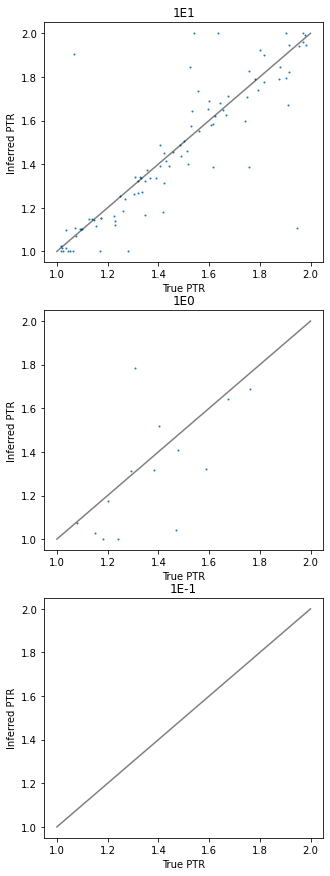

In [ ]:
# Are these any good?
fig, axs = plt.subplots(3, 1, figsize=(5, 15))
for i, multiplier in enumerate(range(MAX_MULT, MIN_MULT, -1)):
    # Idempotent directory move
    ! mv {dd}/fastq_1E{multiplier}/aptr_* {dd}/fastq_1E{multiplier}/aptr_results
    
    aptr_results = pd.read_csv(f"{dd}/fastq_1E{multiplier}/aptr_results/inferred_ptrs.tsv", sep="\t", dtype={0: str})
    aptr_results = aptr_results.set_index(aptr_results.columns[0])

    true_ptrs = pd.read_csv(f"{dd}/log2_ptrs_1E{multiplier}.tsv", sep="\t", dtype={0: str})
    true_ptrs = true_ptrs.set_index(true_ptrs.columns[0])
    true_ptrs = 2**true_ptrs

    # Compare
    aptr_results = aptr_results.loc[true_ptrs.index]
    true_ptrs = true_ptrs.loc[aptr_results.index]

    # Plot
    axs[i].scatter(true_ptrs, aptr_results, s=1)
    axs[i].set_title(f"1E{multiplier}")
    axs[i].set_xlabel("True PTR")
    axs[i].set_ylabel("Inferred PTR")
    axs[i].plot([1, 2], [1, 2], c="k", alpha=.5)


# Run coPTR
These cells must be executed with the `coptr` conda environment

In [ ]:
# ! conda install -n coptr ipykernel --update-deps --force-reinstall
import pandas as pd

# dd = "../../experiments/synthetic/february2023"
dd = "../../experiments/simulated/october2023"
MAX_MULT = 1
MIN_MULT = -2

In [ ]:
# Step 1: Get all of the FASTA files we used and make an index

genomes = set()
for multiplier in range(MAX_MULT, MIN_MULT, -1):
    genomes |= set(pd.read_table(f"{dd}/log2_ptrs_1E{multiplier}.tsv", dtype={0: str}).iloc[:,0])

print(genomes)

! mkdir -p {dd}/coptr
! mkdir -p {dd}/coptr/seqs
! mkdir -p {dd}/coptr/index
for genome in genomes:
    ! cp ../../data/seqs/{genome}.fna {dd}/coptr/seqs

! coptr index {dd}/coptr/seqs {dd}/coptr/index/seqs

{'2045.3', '37659.3', '632518.3', '246194.6', '1262449.8', '1379870.5', '1123518.3', '634503.3', '529120.14', '592031.3', '743721.3', '436113.7', '862965.3', '867900.3', '267747.3', '383372.6', '479436.6', '435590.9', '457431.3', '818.23', '748449.3', '458817.8', '692420.6', '640131.3', '1028989.3', '2113.3', '504728.9', '630626.3', '398579.7', '945021.8', '1536773.3', '435591.13', '405948.11', '880478.3', '759620.7', '64471.13', '457425.27', '485918.6', '637905.5', '457428.4', '1125863.3', '936155.3', '262768.5', '1695218.3', '656519.3', '60480.19', '1246626.3', '447217.5', '1042156.4', '498761.4', '983952.3', '309799.4', '1094497.3', '135487.3', '198628.6', '759620.6', '157783.3', '1392490.5', '390333.7'}
[INFO] [Feb 09, 2023 16:54:32] [coptr.read_mapper] Found 59 files totaling 0.226 GB.
[INFO] [Feb 09, 2023 16:54:32] [coptr.read_mapper] Copying FASTA files to coptr-fna-2023-02-09T21:54:32+00:00.fna with prepended genome ids (filenames).
[INFO] [Feb 09, 2023 16:54:33] [coptr.read_ma

In [ ]:
# Step 2: run coPTR on each directory of FASTQ files

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! mkdir -p {dd}/coptr/bam_1E{multiplier}
    ! coptr map {dd}/coptr/index/seqs {dd}/fastq_1E{multiplier} {dd}/coptr/bam_1E{multiplier} --threads 12

[INFO] [Feb 09, 2023 18:31:30] [coptr.read_mapper] Mapping ../../experiments/synthetic/february2023/fastq_1E1 to ../../experiments/synthetic/february2023/coptr/bam_1E1/Sample_0.sam
[INFO] [Feb 09, 2023 18:31:30] [coptr.read_mapper] bowtie2 -x ../../experiments/synthetic/february2023/coptr/index/seqs ../../experiments/synthetic/february2023/fastq_1E1/Sample_0.fastq --no-unal -p 12 -k 10
5898925 reads; of these:
  5898925 (100.00%) were unpaired; of these:
    434 (0.01%) aligned 0 times
    5492614 (93.11%) aligned exactly 1 time
    405877 (6.88%) aligned >1 times
99.99% overall alignment rate
[INFO] [Feb 09, 2023 18:36:00] [coptr.read_mapper] Converting ../../experiments/synthetic/february2023/coptr/bam_1E1/Sample_0.sam to ../../experiments/synthetic/february2023/coptr/bam_1E1/Sample_0.bam.
[INFO] [Feb 09, 2023 18:36:43] [coptr.read_mapper] Cleaning up ../../experiments/synthetic/february2023/coptr/bam_1E1/Sample_0.sam.
[INFO] [Feb 09, 2023 18:36:44] [coptr.read_mapper] Mapping ../../

In [ ]:
# Step 3: extract coverage maps

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! mkdir -p {dd}/coptr/coverage_maps_1E{multiplier}
    ! coptr extract {dd}/coptr/bam_1E{multiplier} {dd}/coptr/coverage_maps_1E{multiplier}

[INFO] [Feb 10, 2023 10:09:07] [coptr.bam_processor] Processing ../../experiments/synthetic/february2023/coptr/bam_1E1/Sample_0.bam.
[INFO] [Feb 10, 2023 10:10:09] [coptr.bam_processor] Determining reference genomes.
[INFO] [Feb 10, 2023 10:11:01] [coptr.bam_processor] Collecting multi-mapped reads.
[INFO] [Feb 10, 2023 10:12:41] [coptr.bam_processor] Assigning multi-mapped reads.
[INFO] [Feb 10, 2023 10:13:50] [coptr.bam_processor] Grouping reads by reference genome.
[INFO] [Feb 10, 2023 10:13:51] [coptr.bam_processor] Processing ../../experiments/synthetic/february2023/coptr/bam_1E1/Sample_1.bam.
[INFO] [Feb 10, 2023 10:14:34] [coptr.bam_processor] Determining reference genomes.
[INFO] [Feb 10, 2023 10:15:15] [coptr.bam_processor] Collecting multi-mapped reads.
[INFO] [Feb 10, 2023 10:16:38] [coptr.bam_processor] Assigning multi-mapped reads.
[INFO] [Feb 10, 2023 10:17:16] [coptr.bam_processor] Grouping reads by reference genome.
[INFO] [Feb 10, 2023 10:17:16] [coptr.bam_processor] P

In [ ]:
# Step 4: get PTRs

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! coptr estimate {dd}/coptr/coverage_maps_1E{multiplier} {dd}/coptr/coptr_1E{multiplier}.csv

[INFO] [Feb 10, 2023 12:09:06] [coptr.cli] Grouping reads by reference genome.
[INFO] [Feb 10, 2023 12:09:06] [coptr.cli] Saving to ../../experiments/synthetic/february2023/coptr/coverage_maps_1E1/coverage-maps-genome:
[INFO] [Feb 10, 2023 12:09:06] [coptr.cli] 	Sample_0.cm.pkl
[INFO] [Feb 10, 2023 12:09:06] [coptr.cli] 	Sample_1.cm.pkl
[INFO] [Feb 10, 2023 12:09:07] [coptr.cli] 	Sample_2.cm.pkl
[INFO] [Feb 10, 2023 12:09:07] [coptr.cli] 	Sample_3.cm.pkl
[INFO] [Feb 10, 2023 12:09:07] [coptr.cli] 	Sample_4.cm.pkl
[INFO] [Feb 10, 2023 12:09:08] [coptr.cli] 	Sample_5.cm.pkl
[INFO] [Feb 10, 2023 12:09:09] [coptr.cli] 	Sample_6.cm.pkl
[INFO] [Feb 10, 2023 12:09:09] [coptr.cli] 	Sample_7.cm.pkl
[INFO] [Feb 10, 2023 12:09:09] [coptr.cli] 	Sample_8.cm.pkl
[INFO] [Feb 10, 2023 12:09:13] [coptr.cli] 	Sample_9.cm.pkl
[INFO] [Feb 10, 2023 12:09:13] [coptr.cli] Grouping by reference genome: Complete.
[INFO] [Feb 10, 2023 12:09:13] [coptr.cli] The --restart flag can be used to start from here.
[INF

In [ ]:
# Step 5: get read counts as well

for multiplier in range(MAX_MULT, MIN_MULT, -1):
    ! coptr count {dd}/coptr/coverage_maps_1E{multiplier} {dd}/coptr/coptr_counts_1E{multiplier}.csv

# Compare performance of aPTR and coPTR

Run using the `aPTR` conda environment

(13, 10) (13, 10) (13, 10)
(20, 10) (20, 10) (20, 10)
(20, 10) (20, 10) (20, 10)


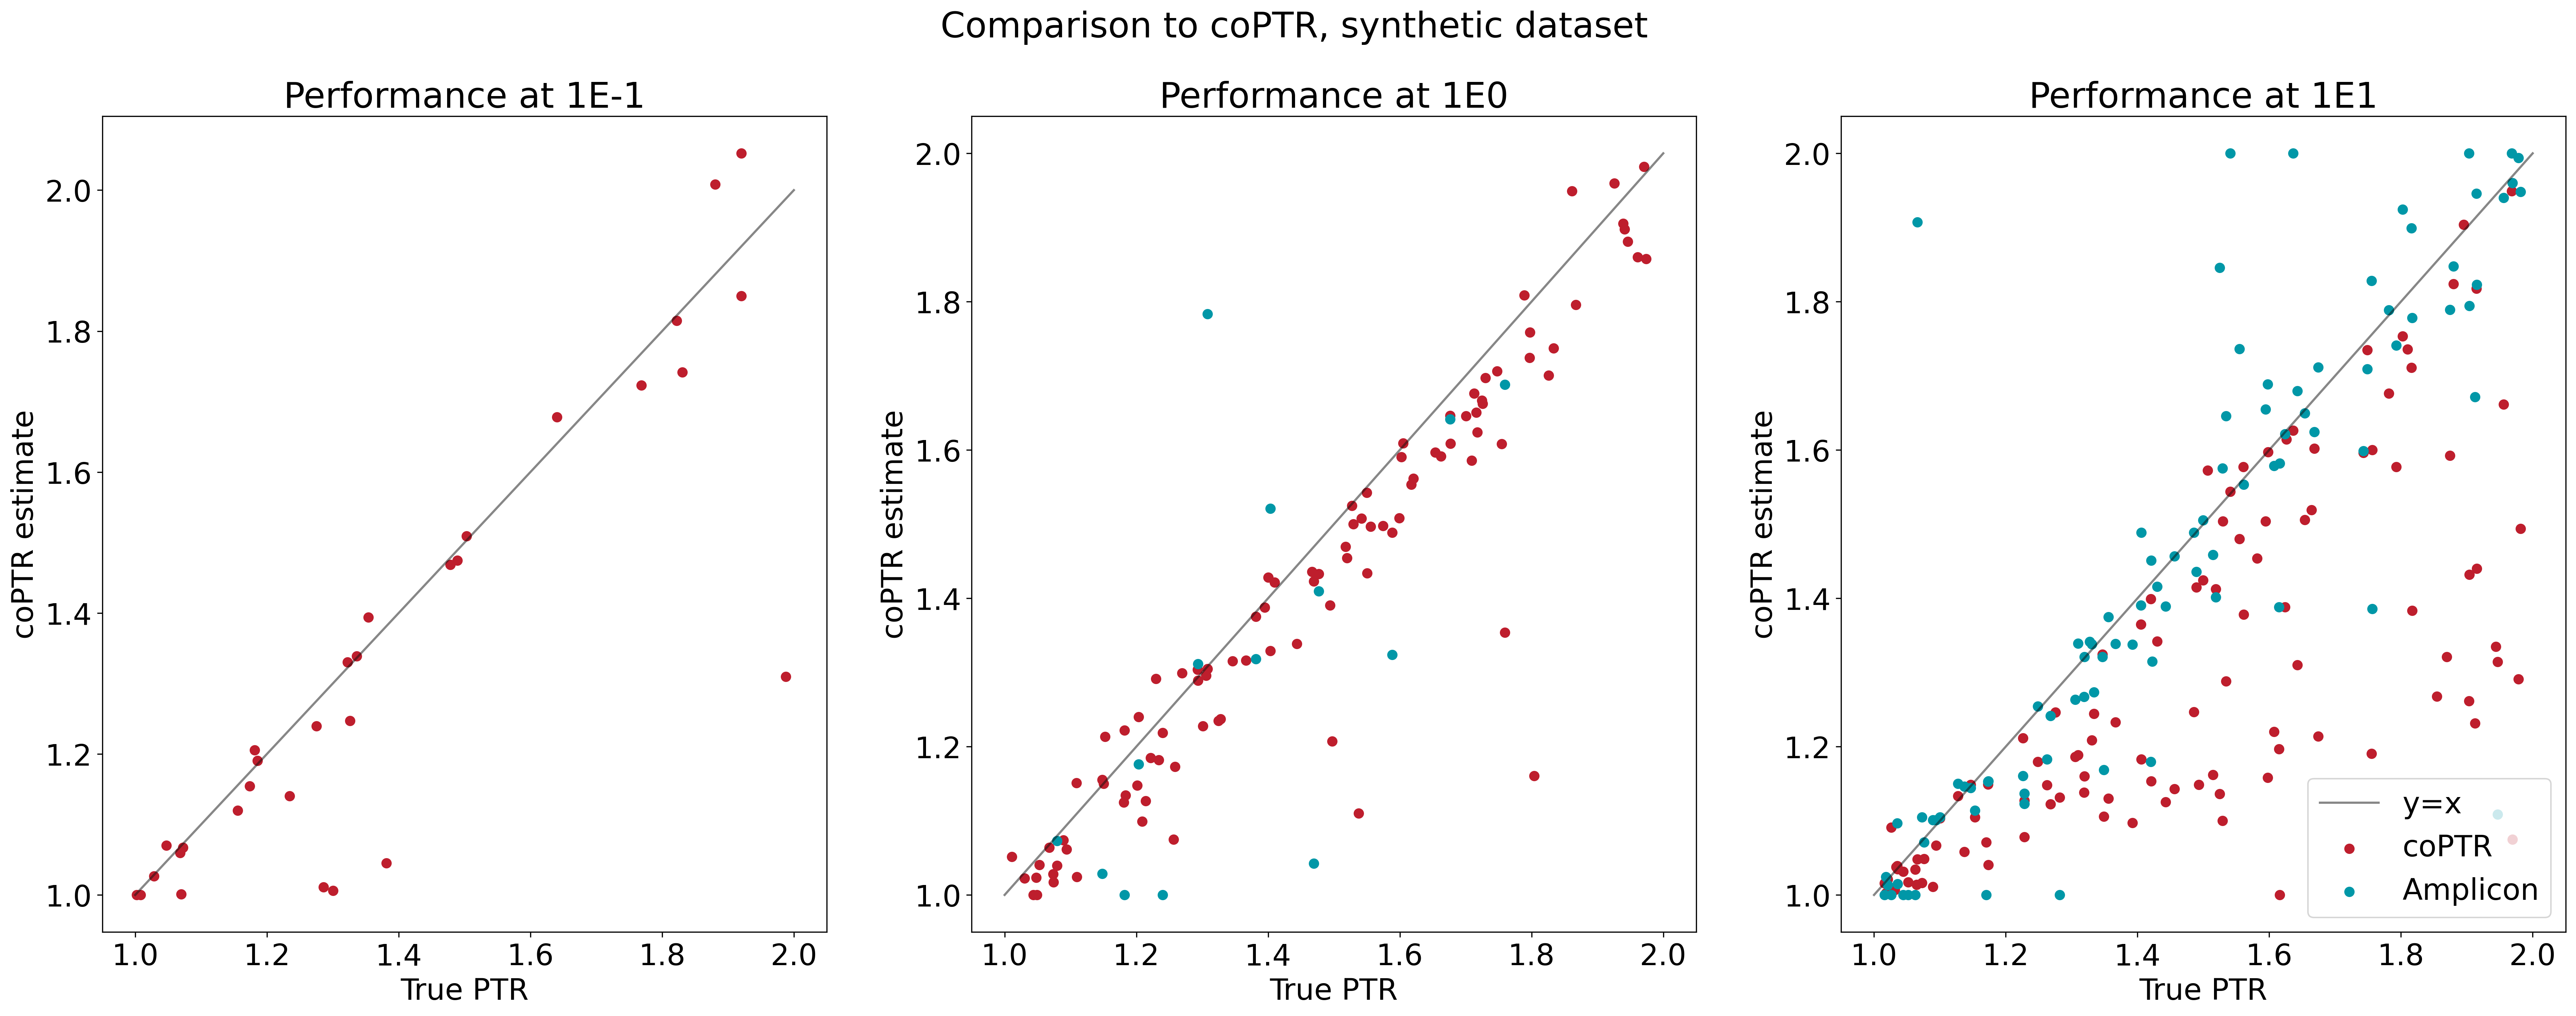

In [ ]:
# Load PTR data, coPTR estimates, and aPTR estimates and compare

plt.rc("font", size=20)

# dd = "../../experiments/simulated/february2023"
dd = "../../experiments/simulated/october2023"
MAX_MULT = 2
MIN_MULT = -1
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for multiplier, ax in zip(range(MIN_MULT, MAX_MULT, 1), axs):
    true_ptrs = pd.read_table(f"{dd}/log2_ptrs_1E{multiplier}.tsv", dtype={0: str})
    true_ptrs = true_ptrs.set_index(true_ptrs.columns[0])
    true_ptrs = 2**true_ptrs

    coptr_estimate = pd.read_csv(f"{dd}/coptr/coptr_1E{multiplier}.csv", dtype={0: str})
    coptr_estimate = coptr_estimate.set_index(coptr_estimate.columns[0])
    coptr_estimate = 2**coptr_estimate

    aptr_estimate = pd.read_table(f"{dd}/fastq_1E{multiplier}/aptr_results/inferred_ptrs.tsv", dtype={0: str})
    aptr_estimate = aptr_estimate.set_index(aptr_estimate.columns[0])

    # Reindex to shared OTUs
    true_ptrs = true_ptrs.reindex(set(coptr_estimate.index) & set(aptr_estimate.index))
    coptr_estimate = coptr_estimate.loc[true_ptrs.index]
    aptr_estimate = aptr_estimate.loc[true_ptrs.index]

    print(true_ptrs.shape, coptr_estimate.shape, aptr_estimate.shape)

    # Non-NA for all
    ax.plot([1, 2], [1, 2], c="#111111", alpha=0.5)
    ax.scatter(true_ptrs.values, coptr_estimate.values, c="#BE1E2D")
    ax.scatter(true_ptrs.values, aptr_estimate.values, c="#0097A7")
    ax.set_xlabel("True PTR")
    ax.set_ylabel("coPTR estimate")
    ax.set_title(f"Performance at 1E{multiplier}")

plt.legend(["y=x", "coPTR", "Amplicon"], loc="lower right")
plt.suptitle("Comparison to coPTR, synthetic dataset")
plt.show()

In [ ]:
# Accuracy vs. number of reads
from aptr import RnaDB
import pickle

coptr_counts_all = pd.DataFrame()
coptr_errors_all = pd.DataFrame()
aptr_counts_all = pd.DataFrame()
aptr_errors_all = pd.DataFrame()

for multiplier in range(MIN_MULT + 2, MAX_MULT, 1):
    coptr_estimate = pd.read_csv(f"{dd}/coptr/coptr_all_1E{multiplier}.csv", dtype={0: str})
    coptr_counts = pd.read_csv(f"{dd}/coptr/coptr_counts_1E{multiplier}.csv", dtype={0: str})
    aptr_estimate = pd.read_table(f"{dd}/fastq_1E{multiplier}/aptr_results/all_inferred_ptrs.tsv", dtype={0: str})
    otus = pd.read_table(f"{dd}/fastq_1E{multiplier}/aptr_results/filtered_otu_table.tsv", dtype={0: str})
    true_ptrs = pd.read_table(f"{dd}/log2_ptrs_1E{multiplier}.tsv", dtype={0: str})

    for df in [coptr_estimate, coptr_counts, aptr_estimate, otus, true_ptrs]:
        df.set_index(df.columns[0], inplace=True)

    coptr_estimate = 2**coptr_estimate
    true_ptrs = 2**true_ptrs

    # Rename columns for coPTR dfs
    coptr_estimate.columns = coptr_counts.columns = aptr_estimate.columns = otus.columns = true_ptrs.columns = [
        f"{multiplier}_{x}" for x in range(10)
    ]

    # Get errors
    idx1 = set(coptr_estimate.index) & set(true_ptrs.index)
    coptr_errors = coptr_estimate.reindex(idx1) - true_ptrs.reindex(idx1)
    idx2 = set(aptr_estimate.index) & set(true_ptrs.index)
    aptr_errors = aptr_estimate.reindex(idx2) - true_ptrs.reindex(idx2)
    print(aptr_errors)

    # Getting read counts for aPTR is tricky - we need to sum over the OTUs
    with open(f"{dd}/fastq_1E{multiplier}/aptr_results/db.pkl", "rb") as f:
        db = pickle.load(f)
    aptr_counts = pd.DataFrame(0, index=aptr_errors.index, columns=aptr_errors.columns)
    for otu in otus.index:
        genomes = db.find_genomes_by_md5(otu)

        # Can add whole rows at once
        for genome in genomes:
            aptr_counts.loc[genome] += otus.loc[otu]

    # Append all as columns
    coptr_counts_all = pd.concat([coptr_counts_all, coptr_counts], axis=1)
    coptr_errors_all = pd.concat([coptr_errors_all, coptr_errors], axis=1)
    aptr_counts_all = pd.concat([aptr_counts_all, aptr_counts], axis=1)
    aptr_errors_all = pd.concat([aptr_errors_all, aptr_errors], axis=1)

# Matplotlib stuff is straightforward
fig = plt.figure(figsize=(15, 10))
plt.scatter(coptr_counts_all, coptr_errors_all, c="#BE1E2D", label="coPTR")
plt.scatter(aptr_counts_all, aptr_errors_all, c="#0097A7", label="Amplicon")
plt.axhline(0, c="#111111", alpha=0.5, label="y=0")
plt.xlabel("Read count")
plt.ylabel("PTR estimate error")

plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

                 1_0       1_1       1_2       1_3       1_4       1_5  \
Unnamed: 0                                                               
1042156.4  -0.109508       NaN       NaN -0.026272       NaN       NaN   
37659.3          NaN  0.055779 -0.105364       NaN -0.028277       NaN   
479436.6   -0.002553       NaN       NaN -0.013962       NaN       NaN   
759620.7   -0.053851       NaN  0.083443       NaN  0.079944  0.013734   
818.23           NaN -0.188725 -0.051863  0.000796  0.037460 -0.053356   
267747.3    0.470207  0.493239       NaN -0.226975  0.459027       NaN   
592031.3         NaN       NaN       NaN       NaN -0.051571       NaN   
637905.5         NaN -0.006304  0.037072 -0.015511 -0.033510       NaN   
759620.6   -0.107434       NaN       NaN  0.104908       NaN -0.026075   
1262449.8        NaN       NaN -0.039202 -0.036114  0.011563       NaN   
1392490.5  -0.179946  0.096519  0.483317  0.072508 -0.240958       NaN   
1379870.5  -0.091185 -0.038848 -0.0791

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'